In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.metrics import confusion_matrix,classification_report
import numpy as np
from sklearn.metrics import accuracy_score, f1_score
from imblearn.over_sampling import SMOTE
from sklearn.impute import SimpleImputer
import time

import functions


ALL = False
NO_SMOTE = True
SUB_PROCESSED_DIR = 'processed_lat_lon'
TEST_RATIO = 0.1

dtypes = {
    'msisdn': 'str',
    'start_time': 'str',
    'end_time': 'str',
    'call_event': 'category',
    'other_party': 'str',
    'ismultimedia': 'category',
    'home_area_code': 'str',
    'visit_area_code': 'str',
    'called_home_code': 'str',
    'called_code': 'str',
    'a_serv_type': 'int',
    'long_type1': 'int',
    'roam_type': 'int',
    'a_product_id': 'str',
    'open_datetime': 'str',
    'call_duration': 'int32',
    'cfee': 'float64',
    'lfee': 'float64',
    'hour': 'int8',
    'dayofweek': 'int',
    'phone1_type': 'int',
    'phone2_type': 'int',
    'phone1_loc_city': 'str',
    'phone1_loc_province': 'str',
    'phone2_loc_city': 'str',
    'phone2_loc_province': 'str',
    'update_time': 'str',
    'date': 'str',
    'date_c': 'str',

    "phone1_loc_city_lat": "float64",
    "phone1_loc_city_lon": "float64",
    "phone2_loc_city_lat": "float64",
    "phone2_loc_city_lon": "float64",
}

# 判断 processed 文件夹是否存在
import os
if not os.path.exists(f'../self_data/{SUB_PROCESSED_DIR}'):
    print("Creating processed data folder...")
    # 读取CSV文件
    labeled_data = pd.read_csv('../self_data/trainSet_city_name_updated_with_lat_lon_patching.csv', dtype=dtypes)
    labels = pd.read_csv('../self_data/all_trainSet_ans.csv', dtype=dtypes)
    validation_data = pd.read_csv('../self_data/validSet_city_name_updated_with_lat_lon_patching.csv', dtype=dtypes)

    # 按照 msisdn 切分 train_data 和 test_data
    train_data_msisdn, test_data_msisdn = train_test_split(labels['msisdn'], test_size=TEST_RATIO, random_state=42, stratify=labels['is_sa'])
    train_data = labeled_data[labeled_data['msisdn'].isin(train_data_msisdn)]
    train_labels = labels[labels['msisdn'].isin(train_data_msisdn)]
    assert len(train_data['msisdn'].unique()) == len(train_data_msisdn)

    test_data = labeled_data[labeled_data['msisdn'].isin(test_data_msisdn)]
    test_labels = labels[labels['msisdn'].isin(test_data_msisdn)]
    assert len(test_data['msisdn'].unique()) == len(test_data_msisdn)

    train_data, train_labels, labels_aug = functions.augment_data_parallel(train_data, train_labels, test_labels)

    # save
    print("Saving processed data...")
    os.makedirs(f'../self_data/{SUB_PROCESSED_DIR}', exist_ok=True)
    train_data.to_pickle(f'../self_data/{SUB_PROCESSED_DIR}/train_data.pkl')
    train_labels.to_pickle(f'../self_data/{SUB_PROCESSED_DIR}/train_labels.pkl')
    test_data.to_pickle(f'../self_data/{SUB_PROCESSED_DIR}/test_data.pkl')
    test_labels.to_pickle(f'../self_data/{SUB_PROCESSED_DIR}/test_labels.pkl')
    labels_aug.to_pickle(f'../self_data/{SUB_PROCESSED_DIR}/labels_aug.pkl')
    validation_data.to_pickle(f'../self_data/{SUB_PROCESSED_DIR}/validation_data.pkl')

else:
    print("Reading processed data...")
    train_data = pd.read_pickle(f'../self_data/{SUB_PROCESSED_DIR}/train_data.pkl')
    train_labels = pd.read_pickle(f'../self_data/{SUB_PROCESSED_DIR}/train_labels.pkl')
    test_data = pd.read_pickle(f'../self_data/{SUB_PROCESSED_DIR}/test_data.pkl')
    test_labels = pd.read_pickle(f'../self_data/{SUB_PROCESSED_DIR}/test_labels.pkl')
    labels_aug = pd.read_pickle(f'../self_data/{SUB_PROCESSED_DIR}/labels_aug.pkl')
    validation_data = pd.read_pickle(f'../self_data/{SUB_PROCESSED_DIR}/validation_data.pkl')

labeled_data_aug = pd.concat([train_data, test_data], ignore_index=True).reindex()
assert len(labeled_data_aug['msisdn'].unique()) == len(labels_aug['msisdn'].unique())

# 转换时间格式
labeled_data_aug['start_time'] = pd.to_datetime(labeled_data_aug['start_time'], format='%Y%m%d%H%M%S')
labeled_data_aug['end_time'] = pd.to_datetime(labeled_data_aug['end_time'], format='%Y%m%d%H%M%S')
labeled_data_aug['open_datetime'] = pd.to_datetime(labeled_data_aug['open_datetime'], format='%Y%m%d%H%M%S')
labeled_data_aug['update_time'] = pd.to_datetime(labeled_data_aug['update_time'])
labeled_data_aug['date'] = pd.to_datetime(labeled_data_aug['date'])

validation_data['start_time'] = pd.to_datetime(validation_data['start_time'], format='%Y%m%d%H%M%S')
validation_data['end_time'] = pd.to_datetime(validation_data['end_time'], format='%Y%m%d%H%M%S')
validation_data['open_datetime'] = pd.to_datetime(validation_data['open_datetime'], format='%Y%m%d%H%M%S',errors='coerce')
validation_data['update_time'] = pd.to_datetime(validation_data['update_time'])
validation_data['date'] = pd.to_datetime(validation_data['date'])

Reading processed data...


In [2]:
# 为每条记录添加start_time_diff，记录 start_time 与上一条记录的 start_time 之差 (单位：秒)
start_time_diff = labeled_data_aug.groupby('msisdn')['start_time'].diff().dt.total_seconds().fillna(0).reset_index(drop=True)
# 将该列加入到数据集中
labeled_data_aug['start_time_diff'] = start_time_diff.copy()
start_time_diff = validation_data.groupby('msisdn')['start_time'].diff().dt.total_seconds().fillna(0).reset_index(drop=True)
validation_data['start_time_diff'] = start_time_diff.copy()

In [3]:
# 为每条记录添加添加 start_day_diff, 记录 start_day 与上一条记录的 start_day 之差 (单位：天)
start_day_diff = labeled_data_aug.groupby('msisdn')['start_day'].diff().fillna(0).reset_index(drop=True)
# 将该列加入到数据集中
labeled_data_aug['start_day_diff'] = start_day_diff.copy()
start_day_diff = validation_data.groupby('msisdn')['start_day'].diff().fillna(0).reset_index(drop=True)
validation_data['start_day_diff'] = start_day_diff.copy()

数据特征处理

In [5]:
labeled_aug_features = functions.aggregate_features_parallel(labeled_data_aug)
validation_features = functions.aggregate_features_parallel(validation_data)

# 合并标签数据
labeled_aug_features = labeled_aug_features.merge(labels_aug, on='msisdn', how='left')

Using 18 workers to aggregate features...


/home/shiwenbo/pros/ensemble_learning/code/functions.py:271: RuntimeWarning: invalid value encountered in scalar divide
  return x[x != x.shift()].count() / x.count()
/home/shiwenbo/pros/ensemble_learning/code/functions.py:275: RuntimeWarning: invalid value encountered in scalar divide
  return x[x != x.shift()].count() / x.count()


Using 18 workers to aggregate features...


In [25]:
functions.get_nan(labeled_aug_features), functions.get_nan(validation_features)

call_duration+std 146
cfee+std 146
lfee+std 146
hour+std 146
dayofweek+std 146
called_home_code+called_diff_home_code 1
called_code+diff 1
start_time_diff+start_time_diff_std 146
start_time_diff+coefficient_of_variation 146
phone1_loc_city_lat+std 146
phone1_loc_city_lon+std 146
phone2_loc_city_lat+std 146
phone2_loc_city_lon+std 146
start_day+std 146
start_day_diff+std 146
call_duration+std 78
cfee+std 78
lfee+std 78
hour+std 78
dayofweek+std 78
start_time_diff+start_time_diff_std 78
start_time_diff+coefficient_of_variation 78
phone1_loc_city_lat+std 78
phone1_loc_city_lon+std 78
phone2_loc_city_lat+std 78
phone2_loc_city_lon+std 78
start_day+std 78
start_day_diff+std 78


(         msisdn  call_duration+sum  call_duration+mean  call_duration+max  \
 330     1005436                 25                25.0                 25   
 945     1010686                 16                16.0                 16   
 1755    1013277                351               351.0                351   
 1950    1013990                 56                56.0                 56   
 2127    1015735                 66                66.0                 66   
 ...         ...                ...                 ...                ...   
 128202  2419249                  2                 2.0                  2   
 129292  2423456                 14                14.0                 14   
 132326  2500562                 23                23.0                 23   
 132693  2502357                 74                74.0                 74   
 132764  2502602                507               507.0                507   
 
         call_duration+std  call_duration+quantile_25  \
 330 

In [26]:
# 一般只有 std 会出现 nan 值故所有的 nan 值填充为 0
labeled_aug_features = labeled_aug_features.fillna(0)
validation_features = validation_features.fillna(0)
functions.get_nan(labeled_aug_features), functions.get_nan(validation_features)

(Empty DataFrame
 Columns: [msisdn, call_duration+sum, call_duration+mean, call_duration+max, call_duration+std, call_duration+quantile_25, call_duration+quantile_50, call_duration+quantile_75, cfee+sum, cfee+std, cfee+mean, lfee+sum, lfee+mean, lfee+std, hour+mean, hour+std, hour+max, hour+min, dayofweek+std, dayofweek+magic, dayofweek+work_day_num, dayofweek+weekend_num, dayofweek+mode, dayofweek+work_day_weekend_diff, visit_area_code+nunique, visit_area_code+times_not_at_home_area, called_home_code+nunique, called_home_code+called_diff_home_code, called_code+nunique, called_code+diff, open_datetime+open_count, other_party+account_person_num, other_party+called_diff_home_code, a_serv_type+call_num, a_serv_type+called_num, a_serv_type+call_called_normalized_diff, start_time_diff+start_time_diff_mean, start_time_diff+start_time_diff_std, start_time_diff+max, start_time_diff+coefficient_of_variation, phone1_loc_city_lat+mean, phone1_loc_city_lat+std, phone1_loc_city_lat+max, phone1_loc_

In [6]:
X = labeled_aug_features.drop(['msisdn'], axis=1)
y = labeled_aug_features['is_sa']
X_validation = validation_features.drop(['msisdn'], axis=1)

n_sample = y.shape[0]
n_pos_sample = y[y ==1].shape[0]
n_neg_sample = y[y == 0].shape[0]
print('样本个数：{}; 正样本占{:.2%}; 负样本占{:.2%}'.format(n_sample,
                                                   n_pos_sample / n_sample,
                                                   n_neg_sample / n_sample))
print('特征维数：', X.shape[1])

样本个数：133591; 正样本占29.31%; 负样本占70.69%
特征维数： 64


In [28]:
labeled_aug_features.columns

Index(['msisdn', 'call_duration+sum', 'call_duration+mean',
       'call_duration+max', 'call_duration+std', 'call_duration+quantile_25',
       'call_duration+quantile_50', 'call_duration+quantile_75', 'cfee+sum',
       'cfee+std', 'cfee+mean', 'lfee+sum', 'lfee+mean', 'lfee+std',
       'hour+mean', 'hour+std', 'hour+max', 'hour+min', 'dayofweek+std',
       'dayofweek+magic', 'dayofweek+work_day_num', 'dayofweek+weekend_num',
       'dayofweek+mode', 'dayofweek+work_day_weekend_diff',
       'visit_area_code+nunique', 'visit_area_code+times_not_at_home_area',
       'called_home_code+nunique', 'called_home_code+called_diff_home_code',
       'called_code+nunique', 'called_code+diff', 'open_datetime+open_count',
       'other_party+account_person_num', 'other_party+called_diff_home_code',
       'a_serv_type+call_num', 'a_serv_type+called_num',
       'a_serv_type+call_called_normalized_diff',
       'start_time_diff+start_time_diff_mean',
       'start_time_diff+start_time_diff_std

In [29]:
# TODO use all_X to impute
imputer = SimpleImputer(strategy='most_frequent')
X = imputer.fit_transform(X)

In [30]:
imputer2 = SimpleImputer(strategy='most_frequent')
X_validation = imputer2.fit_transform(X_validation)

In [31]:
assert len(train_labels) + len(test_labels) == len(labeled_aug_features)
len(train_labels), len(test_labels)

(129732, 3859)

In [32]:
from sklearn.utils import shuffle
# 将 msisdn 和 is_sa 并入 X 再划分
train_data_msisdn = train_labels['msisdn']
test_data_msisdn = test_labels['msisdn']
X_df = pd.DataFrame(X, columns=labeled_aug_features.drop(['msisdn'], axis=1).columns)
X_df = pd.concat([labeled_aug_features[['msisdn']], X_df], axis=1)
train_set = X_df[X_df['msisdn'].isin(train_data_msisdn)][X_df.columns[1:]]
test_set = X_df[X_df['msisdn'].isin(test_data_msisdn)][X_df.columns[1:]]

print(f"1 samples / 0 samples in train set: {len(train_set[train_set['is_sa'] == 1])} / {len(train_set[train_set['is_sa'] == 0])}")
print(f"1 samples / 0 samples in test set: {len(test_set[test_set['is_sa'] == 1])} / {len(test_set[test_set['is_sa'] == 0])}")

if ALL:
    train_len = len(test_set) + len(train_set)
    test_len = 0
else:
    train_len, test_len = len(train_set), len(test_set)

1 samples / 0 samples in train set: 38768 / 90964
1 samples / 0 samples in test set: 384 / 3475


In [33]:
columns = labeled_aug_features.columns.tolist()
columns.remove('msisdn')
valid_set = np.c_[X_validation, np.zeros(X_validation.shape[0])]
valid_set = pd.DataFrame(valid_set, columns=columns)
valid_set['is_sa'] = -1

In [34]:
train_set.head()

,call_duration+sum,call_duration+mean,call_duration+max,call_duration+std,call_duration+quantile_25,call_duration+quantile_50,call_duration+quantile_75,cfee+sum,cfee+std,cfee+mean,...,phone2_loc_city_lon+min,start_day+mean,start_day+std,start_day+max,start_day+min,start_day_diff+mean,start_day_diff+std,start_day_diff+max,start_day_diff+min,is_sa
0,6369.0,68.483871,1129.0,128.481906,20.0,37.0,78.00,0.0,0.0,0.0,...,114.299935,8.580645,4.414213,14.0,0.0,0.150538,0.359536,1.0,0.0,0.0
1,5987.0,71.273810,1129.0,134.445524,20.5,37.0,78.50,0.0,0.0,0.0,...,114.299935,8.523810,4.451820,14.0,0.0,0.166667,0.374916,1.0,0.0,0.0
2,5909.0,70.345238,1129.0,134.744336,19.0,37.0,75.75,0.0,0.0,0.0,...,114.299935,8.309524,4.385013,14.0,0.0,0.166667,0.374916,1.0,0.0,0.0
3,375.0,20.833333,156.0,39.165186,3.5,8.0,13.50,0.0,0.0,0.0,...,108.362721,2.388889,0.978528,3.0,0.0,0.166667,0.383482,1.0,0.0,1.0
4,374.0,22.000000,156.0,40.046848,5.0,8.0,15.00,0.0,0.0,0.0,...,108.362721,2.352941,0.996317,3.0,0.0,0.176471,0.392953,1.0,0.0,1.0


In [35]:
test_set.describe()

,call_duration+sum,call_duration+mean,call_duration+max,call_duration+std,call_duration+quantile_25,call_duration+quantile_50,call_duration+quantile_75,cfee+sum,cfee+std,cfee+mean,...,phone2_loc_city_lon+min,start_day+mean,start_day+std,start_day+max,start_day+min,start_day_diff+mean,start_day_diff+std,start_day_diff+max,start_day_diff+min,is_sa
count,3859.000000,3859.000000,3859.000000,3859.000000,3859.000000,3859.000000,3859.000000,3859.000000,3859.000000,3859.000000,...,3859.000000,3859.000000,3859.000000,3859.000000,3859.0,3859.000000,3859.000000,3859.000000,3859.0,3859.000000
mean,10406.521897,98.551688,1019.947396,161.949909,22.429386,44.574112,101.245400,118.738015,2.351438,1.248072,...,105.446769,7.003929,4.207854,13.302928,0.0,0.300426,0.564667,2.031874,0.0,0.099508
std,12760.882888,92.222400,1033.736896,173.551887,16.044677,37.889841,113.887055,700.271881,21.844227,22.155837,...,18.191903,1.635734,0.827350,2.258839,0.0,0.398423,0.562087,1.579177,0.0,0.299381
min,9.000000,7.500000,9.000000,0.000000,3.000000,7.500000,8.750000,0.000000,0.000000,0.000000,...,-100.445882,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.000000
25%,2636.000000,49.842071,327.500000,58.460836,15.000000,28.000000,54.000000,0.000000,0.000000,0.000000,...,104.063372,6.388192,4.004356,14.000000,0.0,0.091503,0.294547,1.000000,0.0,0.000000
50%,6210.000000,74.507692,702.000000,108.303908,20.000000,37.500000,75.500000,0.000000,0.000000,0.000000,...,108.915000,7.142857,4.317167,14.000000,0.0,0.177215,0.400704,2.000000,0.0,0.000000
75%,13446.500000,114.641912,1437.000000,206.710735,25.250000,50.000000,111.000000,0.000000,0.000000,0.000000,...,114.299935,7.854545,4.595841,14.000000,0.0,0.342105,0.616171,2.000000,0.0,0.000000
max,148852.000000,1585.351351,12031.000000,2985.972392,557.500000,1078.000000,2462.750000,13060.000000,1158.022021,1345.500000,...,139.391956,12.615385,8.082904,14.000000,0.0,5.000000,8.082904,14.000000,0.0,1.000000


In [36]:
all_set = pd.concat([train_set, test_set, valid_set], axis=0).reset_index(drop=True)
labeled_data_len = train_set.shape[0] + test_set.shape[0]

In [37]:
test_set.shape, train_set.shape, valid_set.shape, all_set.shape

((3859, 64), (129732, 64), (13005, 64), (146596, 64))

In [38]:
labeled_set, valid_set = all_set.iloc[:labeled_data_len].copy(), all_set.iloc[labeled_data_len:].copy()
labeled_set.reset_index(drop=True, inplace=True)
valid_set.reset_index(drop=True, inplace=True)
# 有一些值在SMOTE后对数变换后为 NaN，需要删除这些数据
print(labeled_set.isnull().sum().sum())
labeled_set = labeled_set.dropna()
print(labeled_set.isnull().sum().sum())
assert valid_set.shape[0] == validation_features.shape[0]

# 重新划分训练集和测试集
if not ALL:
    train_set, test_set = labeled_set.iloc[:train_len].copy(), labeled_set.iloc[train_len:].copy()
    train_set.reset_index(drop=True, inplace=True)
    test_set.reset_index(drop=True, inplace=True)


    # remove_columns = ['cfee+std', 'start_time_diff+start_time_diff_std', 'lfee+mean', 'lfee+sum', 'lfee+std', 'start_time_diff+max']
    remove_columns = ['lfee+mean', 'lfee+sum', 'lfee+std', 'start_day_diff+max', 'dayofweek+work_day_weekend_diff', 'phone2_loc_city_lon+min']
    train_set = train_set.drop(remove_columns, axis=1)
    test_set = test_set.drop(remove_columns, axis=1)
    valid_set = valid_set.drop(remove_columns, axis=1)
    assert train_set.shape[1] == test_set.shape[1] == valid_set.shape[1]
   
else:
    remove_columns = ['cfee+std', 'start_time_diff+start_time_diff_std', 'lfee+mean', 'lfee+sum', 'lfee+std']
    labeled_set = labeled_set.drop(remove_columns, axis=1)
    valid_set = valid_set.drop(remove_columns, axis=1)
    test_set = test_set.drop(remove_columns, axis=1)
    assert labeled_set.shape[1] == valid_set.shape[1] == test_set.shape[1]
    
# 对采样数据做 smote
if not NO_SMOTE:
    smote = SMOTE(random_state=42)    # 处理过采样的方法
    X_train, y_train = smote.fit_resample(train_set.drop(['is_sa'], axis=1), train_set['is_sa'])
    train_set = pd.concat([X_train, y_train], axis=1)
    print('通过SMOTE方法平衡正负样本后')
    n_sample = y_train.shape[0]
    n_pos_sample = y_train[y_train == 1].shape[0]
    n_neg_sample = y_train[y_train == 0].shape[0]
    print('样本个数：{}; 正样本占{:.2%}; 负样本占{:.2%}'.format(n_sample,
                                                    n_pos_sample / n_sample,
                                                    n_neg_sample / n_sample))

0
0


In [39]:
train_set.shape, test_set.shape, valid_set.shape

((129732, 58), (3859, 58), (13005, 58))

In [40]:
from autogluon.tabular import TabularPredictor

if not ALL:
    model = TabularPredictor(label='is_sa', eval_metric='f1', problem_type='binary').fit(train_set, presets='medium_quality', time_limit=3600)
else:
    model = TabularPredictor(label='is_sa', eval_metric='f1', problem_type='binary').fit(labeled_set, presets='best_quality', num_bag_folds=10, time_limit=3600)

/home/shiwenbo/miniforge3/envs/ag-gpu/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
No path specified. Models will be saved in: "AutogluonModels/ag-20241103_043916"
Verbosity: 2 (Standard Logging)
=================== System Info ===================
AutoGluon Version:  1.1.1
Python Version:     3.10.13
Operating System:   Linux
Platform Machine:   x86_64
Platform Version:   #1 SMP Fri Mar 29 23:14:13 UTC 2024
CPU Count:          48
Memory Avail:       24.28 GB / 62.74 GB (38.7%)
Disk Space Avail:   77.26 GB / 250.92 GB (30.8%)
Presets specified: ['medium_quality']
Beginning AutoGluon training ... Time limit = 3600s
AutoGluon will save models to "AutogluonModels/ag-20241103_043916"
Train Data Rows:    129732
Train Data Columns: 57
Label Column:       is_sa
Problem Type:       binary
Preprocessing data .

[1000]	valid_set's binary_logloss: 0.214805	valid_set's f1: 0.875089
[2000]	valid_set's binary_logloss: 0.137369	valid_set's f1: 0.948735
[3000]	valid_set's binary_logloss: 0.0916993	valid_set's f1: 0.983914
[4000]	valid_set's binary_logloss: 0.0624169	valid_set's f1: 0.990591
[5000]	valid_set's binary_logloss: 0.0436427	valid_set's f1: 0.99328
[6000]	valid_set's binary_logloss: 0.0312424	valid_set's f1: 0.993956
[7000]	valid_set's binary_logloss: 0.0227334	valid_set's f1: 0.994624
[8000]	valid_set's binary_logloss: 0.0166867	valid_set's f1: 0.995973
[9000]	valid_set's binary_logloss: 0.0129847	valid_set's f1: 0.995973
[10000]	valid_set's binary_logloss: 0.0103455	valid_set's f1: 0.995973


	0.996	 = Validation score   (f1)
	77.43s	 = Training   runtime
	0.08s	 = Validation runtime
Fitting model: LightGBM ... Training model for up to 3520.59s of the 3520.59s of remaining time.


[1000]	valid_set's binary_logloss: 0.150873	valid_set's f1: 0.941176
[2000]	valid_set's binary_logloss: 0.075016	valid_set's f1: 0.987171
[3000]	valid_set's binary_logloss: 0.0405446	valid_set's f1: 0.99328
[4000]	valid_set's binary_logloss: 0.0235553	valid_set's f1: 0.995299


	0.9953	 = Validation score   (f1)
	32.51s	 = Training   runtime
	0.02s	 = Validation runtime
Fitting model: RandomForestGini ... Training model for up to 3487.95s of the 3487.95s of remaining time.
	0.9939	 = Validation score   (f1)
	7.76s	 = Training   runtime
	0.18s	 = Validation runtime
Fitting model: RandomForestEntr ... Training model for up to 3479.58s of the 3479.57s of remaining time.
	0.9926	 = Validation score   (f1)
	8.67s	 = Training   runtime
	0.21s	 = Validation runtime
Fitting model: CatBoost ... Training model for up to 3470.32s of the 3470.31s of remaining time.
	0.9966	 = Validation score   (f1)
	197.9s	 = Training   runtime
	0.02s	 = Validation runtime
Fitting model: ExtraTreesGini ... Training model for up to 3272.36s of the 3272.36s of remaining time.
	0.9946	 = Validation score   (f1)
	4.76s	 = Training   runtime
	0.16s	 = Validation runtime
Fitting model: ExtraTreesEntr ... Training model for up to 3266.72s of the 3266.72s of remaining time.
	0.9953	 = Validatio

[1000]	valid_set's binary_logloss: 0.0500428	valid_set's f1: 0.992593


	0.9966	 = Validation score   (f1)
	31.82s	 = Training   runtime
	0.02s	 = Validation runtime
Fitting model: WeightedEnsemble_L2 ... Training model for up to 360.0s of the 2874.62s of remaining time.
	Ensemble Weights: {'LightGBMLarge': 1.0}
	0.9966	 = Validation score   (f1)
	0.52s	 = Training   runtime
	0.0s	 = Validation runtime
AutoGluon training complete, total runtime = 726.08s ... Best model: WeightedEnsemble_L2 | Estimated inference throughput: 95152.1 rows/s (2500 batch size)
TabularPredictor saved. To load, use: predictor = TabularPredictor.load("AutogluonModels/ag-20241103_043916")


In [41]:
if not ALL:
    print(model.evaluate(test_set))

{'f1': 0.4463667820069204, 'accuracy': 0.9170769629437678, 'balanced_accuracy': 0.6586162320143885, 'mcc': 0.4345930598918243, 'roc_auc': 0.8263159472422063, 'precision': 0.6649484536082474, 'recall': 0.3359375}


In [42]:
feature_importance = model.feature_importance(test_set if not ALL else labeled_set)
print(feature_importance)
feature_importance

These features in provided data are not utilized by the predictor and will be ignored: ['start_day_diff+min']
Computing feature importance via permutation shuffling for 56 features using 3859 rows with 5 shuffle sets...
	18.53s	= Expected runtime (3.71s per shuffle set)
	9.43s	= Actual runtime (Completed 5 of 5 shuffle sets)


                                          importance    stddev   p_value  n  \
called_home_code+nunique                    0.066992  0.008406  0.000029  5   
other_party+account_person_num              0.051944  0.011388  0.000260  5   
start_day+max                               0.041956  0.008749  0.000214  5   
hour+std                                    0.026821  0.006827  0.000463  5   
hour+min                                    0.024651  0.005913  0.000368  5   
start_day+std                               0.024147  0.008748  0.001750  5   
hour+max                                    0.022051  0.005176  0.000339  5   
phone2_loc_city_lat+min                     0.021003  0.004794  0.000304  5   
phone2_loc_city_lon+std                     0.020997  0.004730  0.000289  5   
a_serv_type+call_called_normalized_diff     0.019222  0.009636  0.005578  5   
call_duration+quantile_75                   0.018999  0.001697  0.000008  5   
a_serv_type+call_num                        0.018600

,importance,stddev,p_value,n,p99_high,p99_low
called_home_code+nunique,0.066992,0.008406,0.000029,5,0.084301,0.049683
other_party+account_person_num,0.051944,0.011388,0.000260,5,0.075392,0.028497
start_day+max,0.041956,0.008749,0.000214,5,0.059970,0.023942
hour+std,0.026821,0.006827,0.000463,5,0.040878,0.012765
hour+min,0.024651,0.005913,0.000368,5,0.036825,0.012477
start_day+std,0.024147,0.008748,0.001750,5,0.042160,0.006134
hour+max,0.022051,0.005176,0.000339,5,0.032708,0.011394
phone2_loc_city_lat+min,0.021003,0.004794,0.000304,5,0.030874,0.011132
phone2_loc_city_lon+std,0.020997,0.004730,0.000289,5,0.030736,0.011259
a_serv_type+call_called_normalized_diff,0.019222,0.009636,0.005578,5,0.039063,-0.000619


In [43]:
# leaderboard
if not ALL:
    leaderboard = model.leaderboard(test_set, silent=True)
    print(leaderboard)
else:
    leaderboard = model.leaderboard(labeled_set, silent=True)
    print(leaderboard)
leaderboard

                  model  score_test  score_val eval_metric  pred_time_test  \
0               XGBoost    0.459283   0.994624          f1        0.139413   
1              LightGBM    0.458472   0.995299          f1        0.073542   
2              CatBoost    0.452342   0.996642          f1        0.083088   
3         LightGBMLarge    0.446367   0.996647          f1        0.064812   
4   WeightedEnsemble_L2    0.446367   0.996647          f1        0.069890   
5        NeuralNetTorch    0.435021   0.984512          f1        0.072642   
6            LightGBMXT    0.432432   0.995973          f1        0.191224   
7      RandomForestEntr    0.366089   0.992593          f1        0.360327   
8      RandomForestGini    0.364341   0.993939          f1        0.426519   
9        ExtraTreesEntr    0.359281   0.995293          f1        0.540982   
10       ExtraTreesGini    0.346232   0.994616          f1        0.572650   
11       KNeighborsUnif    0.193001   0.757797          f1      

,model,score_test,score_val,eval_metric,pred_time_test,pred_time_val,fit_time,pred_time_test_marginal,pred_time_val_marginal,fit_time_marginal,stack_level,can_infer,fit_order
0,XGBoost,0.459283,0.994624,f1,0.139413,0.026276,24.550187,0.139413,0.026276,24.550187,1,True,10
1,LightGBM,0.458472,0.995299,f1,0.073542,0.024965,32.507049,0.073542,0.024965,32.507049,1,True,4
2,CatBoost,0.452342,0.996642,f1,0.083088,0.015361,197.898293,0.083088,0.015361,197.898293,1,True,7
3,LightGBMLarge,0.446367,0.996647,f1,0.064812,0.024283,31.816938,0.064812,0.024283,31.816938,1,True,12
4,WeightedEnsemble_L2,0.446367,0.996647,f1,0.069890,0.026274,32.339720,0.005078,0.001991,0.522782,2,True,13
5,NeuralNetTorch,0.435021,0.984512,f1,0.072642,0.043675,329.982602,0.072642,0.043675,329.982602,1,True,11
6,LightGBMXT,0.432432,0.995973,f1,0.191224,0.078962,77.425127,0.191224,0.078962,77.425127,1,True,3
7,RandomForestEntr,0.366089,0.992593,f1,0.360327,0.211376,8.669680,0.360327,0.211376,8.669680,1,True,6
8,RandomForestGini,0.364341,0.993939,f1,0.426519,0.183723,7.759406,0.426519,0.183723,7.759406,1,True,5
9,ExtraTreesEntr,0.359281,0.995293,f1,0.540982,0.167372,4.237971,0.540982,0.167372,4.237971,1,True,9


              precision    recall  f1-score   support

         0.0       0.93      0.98      0.96      3475
         1.0       0.66      0.34      0.45       384

    accuracy                           0.92      3859
   macro avg       0.80      0.66      0.70      3859
weighted avg       0.90      0.92      0.90      3859



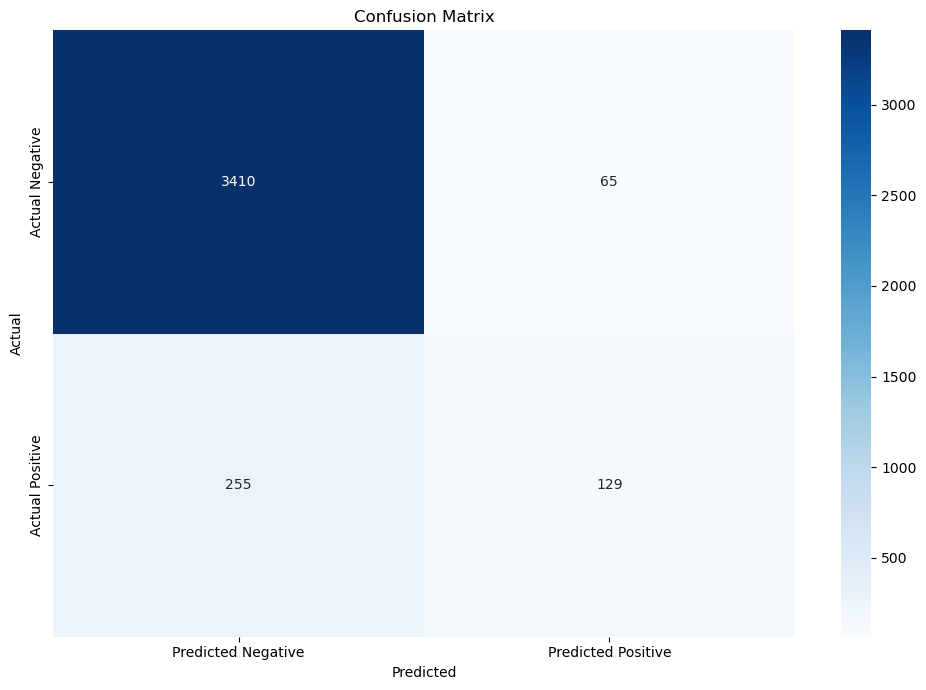

In [44]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

if not ALL:
    y_pred = model.predict(test_set)
    y_true = test_set['is_sa']
    
    print(classification_report(y_true, y_pred))
    
    cm = confusion_matrix(y_true, y_pred)
    
    plt.figure(figsize=(10, 7))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Predicted Negative', 'Predicted Positive'], yticklabels=['Actual Negative', 'Actual Positive'])
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix')
    plt.tight_layout()
    os.makedirs("../vis", exist_ok=True)
    plt.savefig("../vis/confusion_matrix.png")
    plt.show()

In [45]:
# 模型决策阈值微调
threadhold = 0.2
if not ALL:
    y_pred_proba = model.predict_proba(test_set)
    # print(y_pred_proba)
    y_pred = (y_pred_proba.iloc[:, 1] > threadhold).astype(int)
    print(classification_report(y_true, y_pred))
    print(confusion_matrix(y_true, y_pred))

              precision    recall  f1-score   support

         0.0       0.94      0.95      0.94      3475
         1.0       0.49      0.48      0.49       384

    accuracy                           0.90      3859
   macro avg       0.72      0.71      0.72      3859
weighted avg       0.90      0.90      0.90      3859

[[3284  191]
 [ 199  185]]


In [46]:
# 预测
y_validation_pred = model.predict(valid_set.drop('is_sa', axis=1))

# 将预测结果与 msisdn 对应起来
validation_results = validation_features[['msisdn']].copy()
validation_results['is_sa'] = y_validation_pred.astype(int)

print(validation_results.describe())

# 保存结果到CSV文件
time_str = time.strftime("%Y%m%d%H%M%S", time.localtime())
file_name = './valid_large_data_{}.csv'.format(time_str) if ALL else './valid_small_data_{}.csv'.format(time_str)
validation_results.to_csv(file_name, index=False)
print(file_name)

              is_sa
count  13005.000000
mean       0.065744
std        0.247844
min        0.000000
25%        0.000000
50%        0.000000
75%        0.000000
max        1.000000
./valid_small_data_20241103125136.csv


In [47]:
# import numpy as np
# from sklearn.metrics import f1_score, classification_report, confusion_matrix

# # 自动调整最佳阈值
# if not ALL:
#     y_true = test_set['is_sa']
#     y_pred_proba = model.predict_proba(test_set)

#     thresholds = np.arange(0.0, 1.0, 0.01)
#     f1_scores = []

#     for threshold in thresholds:
#         y_pred = (y_pred_proba.iloc[:, 1] >= threshold).astype(int)
#         f1 = f1_score(y_true, y_pred)
#         f1_scores.append(f1)

#     best_threshold = thresholds[np.argmax(f1_scores)]
#     print(f'最佳阈值：{best_threshold}')
#     print(f'最佳 F1 分数：{max(f1_scores)}')

#     # 使用最佳阈值进行预测
#     y_pred = (y_pred_proba.iloc[:, 1] >= best_threshold).astype(int)
#     print(classification_report(y_true, y_pred))
#     print(confusion_matrix(y_true, y_pred))

In [48]:
# # 阈值微调版结果
# best_threshold = 0.3
# # 使用最佳决策阈值进行预测
# y_validation_pred_proba = model.predict_proba(valid_set.drop('is_sa', axis=1))
# y_validation_pred = (y_validation_pred_proba.iloc[:, 1] >= best_threshold).astype(int)

# # 将预测结果与 msisdn 对应起来
# validation_results = validation_features[['msisdn']].copy()
# validation_results['is_sa'] = y_validation_pred.astype(int)

# print(validation_results.describe())

# # 保存结果到CSV文件
# import time
# time_str = time.strftime("%Y%m%d%H%M%S", time.localtime())
# file_name = './valid_large_data_{}.csv'.format(time_str) if ALL else './valid_small_data_{}.csv'.format(time_str)
# validation_results.to_csv(file_name, index=False)
# print(file_name)